<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mountain-Car:-REINFORCE-Monte-Carlo-Policy-Gradients" data-toc-modified-id="Mountain-Car:-REINFORCE-Monte-Carlo-Policy-Gradients-1">Mountain Car: REINFORCE Monte Carlo Policy Gradients</a></span></li><li><span><a href="#This-is-a-notebook-from-Deep-Reinforcement-Learning-Course-with-Tensorflow" data-toc-modified-id="This-is-a-notebook-from-Deep-Reinforcement-Learning-Course-with-Tensorflow-2">This is a notebook from <a href="https://simoninithomas.github.io/Deep_reinforcement_learning_Course/" target="_blank">Deep Reinforcement Learning Course with Tensorflow</a></a></span><ul class="toc-item"><li><span><a href="#Step-1:-Import-the-libraries" data-toc-modified-id="Step-1:-Import-the-libraries-2.1">Step 1: Import the libraries</a></span></li><li><span><a href="#Step-2:-Create-our-environment" data-toc-modified-id="Step-2:-Create-our-environment-2.2">Step 2: Create our environment</a></span></li><li><span><a href="#Step-3:-Set-up-our-hyperparameters" data-toc-modified-id="Step-3:-Set-up-our-hyperparameters-2.3">Step 3: Set up our hyperparameters</a></span></li><li><span><a href="#Step-4-:-Define-the-preprocessing-functions️" data-toc-modified-id="Step-4-:-Define-the-preprocessing-functions️-2.4">Step 4 : Define the preprocessing functions️</a></span></li><li><span><a href="#Step-5:-Create-our-Policy-Gradient-Neural-Network-model" data-toc-modified-id="Step-5:-Create-our-Policy-Gradient-Neural-Network-model-2.5">Step 5: Create our Policy Gradient Neural Network model</a></span></li><li><span><a href="#Step-6:-Set-up-Tensorboard" data-toc-modified-id="Step-6:-Set-up-Tensorboard-2.6">Step 6: Set up Tensorboard</a></span></li><li><span><a href="#Step-7:-Train-our-Agent" data-toc-modified-id="Step-7:-Train-our-Agent-2.7">Step 7: Train our Agent</a></span></li><li><span><a href="#Step-8:-Evaluate-our-trained-model" data-toc-modified-id="Step-8:-Evaluate-our-trained-model-2.8">Step 8: Evaluate our trained model</a></span></li><li><span><a href="#Report" data-toc-modified-id="Report-2.9">Report</a></span></li></ul></li></ul></div>

# Mountain Car: REINFORCE Monte Carlo Policy Gradients

In this notebook we'll implement an agent that plays <b> MountainCar-v0 </b>
<video controls src="./assets/mountain_car.mp4" />

# This is a notebook from [Deep Reinforcement Learning Course with Tensorflow](https://simoninithomas.github.io/Deep_reinforcement_learning_Course/)

The original notebook, with a solution for CartPole is [here](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Policy%20Gradients/Cartpole/Cartpole%20REINFORCE%20Monte%20Carlo%20Policy%20Gradients.ipynb)


## Step 1: Import the libraries

In [1]:
import tensorflow as tf
import numpy as np
import gym

## Step 2: Create our environment
This time we use <a href="https://gym.openai.com/">OpenAI Gym</a> which has a lot of great environments.

In [2]:
# env_name = 'CartPole-v0'
env_name = 'MountainCar-v0'
# env = gym.make('MountainCar-v0')
env = gym.make(env_name)
env = env.unwrapped
# Policy gradient has high variance, seed for reproducability
env.seed(1);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Step 3: Set up our hyperparameters 

In [3]:
## ENVIRONMENT Hyperparameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# print(action_size, state_size)
## TRAINING Hyperparameters
max_episodes = 300
learning_rate = 0.01
STEP_MULTIPLE = 3.0
gamma = 0.95 # Discount rate

## Step 4 : Define the preprocessing functions️
This function takes <b>the rewards and perform discounting.</b>

In [4]:
def discount_and_normalize_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)
    
    return discounted_episode_rewards

## Step 5: Create our Policy Gradient Neural Network model

<img src="./assets/mountain_car.jpeg">

The idea is simple:
- Our state which is an array of 2 values, **position** and **velocity**, which will be used as an input.
- Our NN is 3 fully connected layers.
- Our output activation function is **softmax** that squashes the outputs to a probability distribution:
    - for instance: $ softmax(4,\ 2,\ 6) \rightarrow (0.117,\ 0.016,\ 0.867) $

In [5]:
with tf.device("/device:GPU:1"):
    with tf.name_scope("inputs"):
        input_ = tf.placeholder(tf.float32, [None, state_size], name="input_")
        actions = tf.placeholder(tf.int32, [None, action_size], name="actions")
        discounted_episode_rewards_ = tf.placeholder(
            tf.float32, [None,], name="discounted_episode_rewards")

        # Add this placeholder for having this variable in tensorboard
        mean_reward_ = tf.placeholder(tf.float32 , name="mean_reward")

        with tf.name_scope("fc1"):
            fc1 = tf.contrib.layers.fully_connected(
                inputs = input_, num_outputs = 10,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer()) 
        with tf.name_scope("fc2"):
            fc2 = tf.contrib.layers.fully_connected(
                inputs = fc1, num_outputs = action_size,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

        with tf.name_scope("fc3"):
            fc3 = tf.contrib.layers.fully_connected(
                inputs = fc2, num_outputs = action_size,
                activation_fn= None,
                weights_initializer=tf.contrib.layers.xavier_initializer()) 
            
        with tf.name_scope("softmax"):
            action_distribution = tf.nn.softmax(fc3)

        with tf.name_scope("loss"):
            # tf.nn.softmax_cross_entropy_with_logits computes the cross entropy 
            # of the result after applying the softmax function
            # If you have single-class labels, where an object can only belong to one class,
            # you might now consider using tf.nn.sparse_softmax_cross_entropy_with_logits 
            # so that you don't have to convert your labels to a dense one-hot array. 
            neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(
                logits = fc3, labels = actions)
            loss = tf.reduce_mean(neg_log_prob * discounted_episode_rewards_) 


        with tf.name_scope("train"):
            train_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

## Step 6: Set up Tensorboard
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=./tensorboard/pg/1`

In [6]:
# Setup TensorBoard Writer
# writer = tf.summary.FileWriter("/tensorboard/pg/1")
!rm -Rf ./tensorboard
writer = tf.summary.FileWriter("./tensorboard/pg/1")

## Losses
tf.summary.scalar("Loss", loss)

## Reward mean
tf.summary.scalar("Reward_mean", mean_reward_)

write_op = tf.summary.merge_all()

#!tensorboard --logdir="./tensorboard/pg/1"
!pwd

/home/andrew/Documents/redpanda/move_37/week_8


## Step 7: Train our Agent 

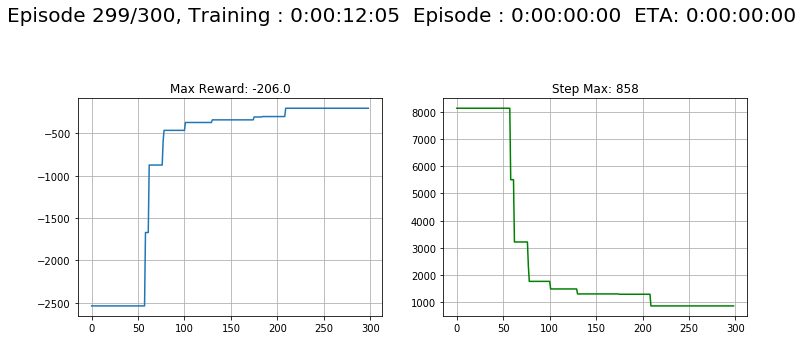

In [7]:
allRewards = []
total_rewards = 0
maximumRewardRecorded = 0
episode = 0
episode_states, episode_actions, episode_rewards = [],[],[]
max_reward_history = []
step_max_history = []
saver = tf.train.Saver()


import datetime
import math
from tqdm import tqdm, tnrange

from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import strftime
%matplotlib inline 

def time_delta_report(time_delta):
    if time_delta is None:
        time_delta = "None"
    else:
        days = time_delta.days
        hours, remainder = divmod(time_delta.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        time_delta = f"{days}:{str(hours).zfill(2)}:{str(minutes).zfill(2)}:{str(seconds).zfill(2)}"
    return time_delta
        
def plot_me(max_reward_history, episode, max_episodes, step_max, max_reward,
            ep_delta, sim_delta):
    clear_output(True)
    fig = plt.figure(figsize=[12, 4])
    remaining_episodes = max_episodes - episode - 1 
   
    if ep_delta is None:
        eta_r = "None"
    else:
        eta_r = time_delta_report(remaining_episodes * ep_delta)
        
    ep_delta_r: str = time_delta_report(ep_delta)
    sim_delta_r = time_delta_report(sim_delta)
    remaining_episodes = max_episodes - episode - 1

    fig.suptitle(f"Episode {episode}/{max_episodes}, "
                 f"Training : {sim_delta_r}  Episode : {ep_delta_r}  "
                 f"ETA: {eta_r}",
                 fontsize=20, y=1.2)
    plt.subplot(1, 2, 1)
    plt.title(f"Max Reward: {max_reward}")
    plt.plot(max_reward_history)
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.title(f"Step Max: {step_max}")
    plt.plot(step_max_history, color="green")
    plt.grid()
    
    plt.show()

step_max = 20000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    old_position, old_velocity = None, None
    time_delta = None
    sim_start_time = datetime.datetime.now()
    sim_delta = None
    for episode in range(max_episodes):
        plot_me(max_reward_history, episode, max_episodes, step_max, maximumRewardRecorded, time_delta, sim_delta)       
        episode_rewards_sum = 0

        # Launch the game
        state = env.reset()
        start_time = datetime.datetime.now()
        
        #env.render()

        episode_max_pos, episode_min_pos = float("-2.0"), float("2.0")
        direction_change_counter = 0
        fail = False
        str_width = int(math.log10(max_episodes)) + 1
        str_episode = str(episode).zfill(str_width)

        for counter in range(step_max):
            # Choose action a, remember WE'RE NOT IN A DETERMINISTIC ENVIRONMENT,
            # WE'RE OUTPUT PROBABILITIES.

            action_probability_distribution = sess.run(
                action_distribution, feed_dict={input_: state.reshape([1,state_size])})
                # select action w.r.t the actions prob 
            action = np.random.choice(
                range(
                    action_probability_distribution.shape[1]),
                    p=action_probability_distribution.ravel())

            new_state, reward, done, info = env.step(action)

            if old_position is None:
                old_position, old_velocity = new_state
            else:
                old_position, old_velocity = position, velocity
                
            position, velocity = new_state
            velocity_sign = velocity * old_velocity
            
            bonus = 0.0
            if velocity_sign < 0.0:
                new_record = False
                direction_change_counter += 1
                if position > episode_max_pos:
                    episode_max_pos = position
                    new_record = True
                elif position < episode_min_pos:
                    episode_min_pos = position
                    new_record = True

                if new_record:
                    bonus = 10.0  # bonus for gaining potential energy
                else:
                    bonus = -2.0  # penalty for wasting potential energy

            reward += bonus
            
            counter += 1
            #if counter == 10:
            #    break
            # Store s, a, r
            episode_states.append(state)
                        
            # For actions because we output only one (the index) we need 2
            # (1 is for the action taken)
            # We need [0., 1.] (if we take right) not just the index
            action_ = np.zeros(action_size)
            action_[action] = 1
            
            episode_actions.append(action_)
            
            episode_rewards.append(reward)
           
            if counter >= step_max:
                # Bad Ending
                if episode <= max_episodes:
                    done = True
                    fail = True
                else:
                    step_max = 1000000
                    
                
            if done:

                if counter < step_max / STEP_MULTIPLE :
                    step_max = int(counter * STEP_MULTIPLE)
                    
                # Calculate sum reward
                episode_rewards_sum = np.sum(episode_rewards)
                
                allRewards.append(episode_rewards_sum)
                
                total_rewards = np.sum(allRewards)
                
                # Mean reward
                mean_reward = np.divide(total_rewards, episode+1)
                
                
                maximumRewardRecorded = np.amax(allRewards)
                max_reward_history.append(maximumRewardRecorded)
                step_max_history.append(step_max)
                # plot_me(max_reward_history, episode, max_episodes)
                end_time = datetime.datetime.now()
                time_delta = end_time - start_time
                sim_delta = end_time - sim_start_time
                
                # Calculate discounted reward
                discounted_episode_rewards = discount_and_normalize_rewards(episode_rewards)
                                
                # Feedforward, gradient and backpropagation
                loss_, _ = sess.run(
                    [loss, train_opt],
                    feed_dict={
                        input_: np.vstack(np.array(episode_states)),
                        actions: np.vstack(np.array(episode_actions)),
                        discounted_episode_rewards_: discounted_episode_rewards 
                    }
                )
                
                # Write TF Summaries
                summary = sess.run(write_op,
                   feed_dict={
                       input_: np.vstack(np.array(episode_states)),
                       actions: np.vstack(np.array(episode_actions)),
                       discounted_episode_rewards_: discounted_episode_rewards,
                       mean_reward_: mean_reward
                   }
                )
                
                writer.add_summary(summary, episode)
                writer.flush()
                
                # Reset the transition stores
                episode_states, episode_actions, episode_rewards = [],[],[]
                
                break
            
            state = new_state
        
        # Save Model
        if episode % 100 == 0:
            saver.save(sess, "./models/model.ckpt")
            print("Model saved")

## Step 8: Evaluate our trained model

Load our model and see if it generalizes well by solving 10 random games and averaging the score

In [8]:
with tf.Session() as sess:
    env.reset()
    rewards = []
    
    # Load the model
    saver.restore(sess, "./models/model.ckpt")

    for episode in range(10):
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        print("****************************************************")
        print("EPISODE ", episode)

        while True:
            

            # Choose action a, remember WE'RE NOT IN A DETERMINISTIC ENVIRONMENT, WE'RE OUTPUT PROBABILITIES.
            action_probability_distribution = sess.run(action_distribution, feed_dict={input_: state.reshape([1, state_size])})
            #print(action_probability_distribution)
            action = np.random.choice(range(action_probability_distribution.shape[1]), p=action_probability_distribution.ravel())  # select action w.r.t the actions prob


            new_state, reward, done, info = env.step(action)

            total_rewards += reward

            if done:
                rewards.append(total_rewards)
                print ("Score", total_rewards)
                break
            state = new_state
    env.close()
    print ("Score over time: " +  str(sum(rewards)/10))

INFO:tensorflow:Restoring parameters from ./models/model.ckpt
****************************************************
EPISODE  0
Score -1018.0
****************************************************
EPISODE  1
Score -738.0
****************************************************
EPISODE  2
Score -540.0
****************************************************
EPISODE  3
Score -1287.0
****************************************************
EPISODE  4
Score -657.0
****************************************************
EPISODE  5
Score -925.0
****************************************************
EPISODE  6
Score -1182.0
****************************************************
EPISODE  7
Score -836.0
****************************************************
EPISODE  8
Score -818.0
****************************************************
EPISODE  9
Score -773.0
Score over time: -877.4


## Report

1.  base run with CartPole environment
2.  changed environment to MountainCar
3.  Changed Neural Network input to match new environment state_space dimensions
4.  Fitness Function Experiments:
     1. score initially improved but was stuck throughout the rest of training. Not very promising
	 2. Designed a new metric, **potential energy (PE)**
         1.  Successfully improving PE during a direction change grants a bonus of +10 reward
         2.  Failure to improve PE during a direction change provides a penalty of -2 reward
	 3. Added a **step limit multiplier** hyperparameter to the training that constrained training episode duration to be a multiple of our fastest training episode. Initial multiple was 1.5. 
         1.  This combined with **experiment B** definitely improved the score further during training. 
         2.  Post training evaluation results were not great.  Rewards were constantly in the negative thousands (~ -5000) 
	 4. We found that the last set of training episodes had very short training times due to the lower step limit multiplier (1.5). To loosen this constraint, we increased the step limit multiplier from 1.5 to 3.0.
         1.  Rewards constantly improved during training as before. 
         2.  Post training evaluation results were much better. Rewards were averaging ~-500. So this change led to an order of magnitude improvement in our evaluation testing.
